# **Denoising with Autoencoder (Deep Learning Model)**

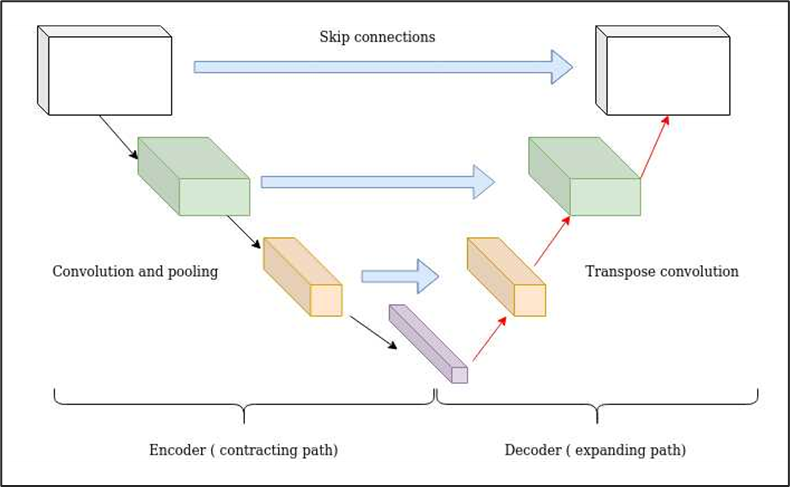

## Clone Repository for Loading Dataset

In [1]:
!git clone https://github.com/Magauiya/Extended_SURE.git

Cloning into 'Extended_SURE'...
remote: Enumerating objects: 799, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 799 (delta 1), reused 85 (delta 1), pack-reused 714 (from 1)
Receiving objects: 100% (799/799), 439.20 MiB | 16.44 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (693/693), done.


## Import Library

In [2]:
from os import listdir, makedirs
from os.path import join

from PIL import Image

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

from torchvision import transforms
import torchvision.transforms.functional as TF

## Create Custom Dataloader

In [3]:
class MyDataLoader(Dataset) :
  def __init__(self, dataroot, is_train, crop_size) :
    # Inheritance
    super(MyDataLoader, self).__init__()

    # Create Data Augmentation Instance
    if is_train :
      self.transforms = transforms.Compose([transforms.RandomCrop((crop_size, crop_size)),
                                            transforms.RandomHorizontalFlip(0.5),
                                            transforms.RandomVerticalFlip(0.5),
                                            transforms.ToTensor()])
    else :
       self.transforms = transforms.Compose([transforms.ToTensor()])

    # Initialize Variable
    self.img_path_list = [join(dataroot, img_name) for img_name in listdir(dataroot) if img_name.split(".")[-1] in ["jpg", "png"]]

  def __getitem__(self, index) :
    img_path = self.img_path_list[index]

    img = Image.open(img_path).convert("RGB")
    img = self.transforms(img)

    return {"img":img}

  def __len__(self) :
    return len(self.img_path_list)

## Create Autoencoder Model Class

In [4]:
class Autoencoder(nn.Module) :
  def __init__(self, in_channels, hid_channels) :
    super().__init__()

    self.encoder_block_0 = nn.Conv2d(in_channels, hid_channels, kernel_size=3, stride=1, padding=1)
    self.encoder_block_1 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2),
                                         nn.Conv2d(hid_channels, hid_channels*2, kernel_size=3, stride=1, padding=1),
                                         nn.ReLU(True))
    self.encoder_block_2 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2),
                                         nn.Conv2d(hid_channels*2, hid_channels*4, kernel_size=3, stride=1, padding=1),
                                         nn.ReLU(True))
    self.encoder_block_3 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2),
                                         nn.Conv2d(hid_channels*4, hid_channels*4, kernel_size=3, stride=1, padding=1),
                                         nn.ReLU(True))

    self.decoder_block_0 = nn.Sequential(nn.Conv2d(hid_channels*4, hid_channels*4, kernel_size=3, stride=1, padding=1),
                                         nn.ReLU(True))
    self.decoder_block_1 = nn.Sequential(nn.Conv2d(hid_channels*4, hid_channels*2, kernel_size=3, stride=1, padding=1),
                                         nn.ReLU(True))
    self.decoder_block_2 = nn.Sequential(nn.Conv2d(hid_channels*2, hid_channels, kernel_size=3, stride=1, padding=1),
                                         nn.ReLU(True))
    self.decoder_block_3 = nn.Conv2d(hid_channels, in_channels, kernel_size=3, stride=1, padding=1)

  def forward(self, x) :
    e_0 = self.encoder_block_0(x)
    e_1 = self.encoder_block_1(e_0)
    e_2 = self.encoder_block_2(e_1)
    e_3 = self.encoder_block_3(e_2)

    d_0 = self.decoder_block_0(F.interpolate(e_3, size=e_2.shape[2:], mode="nearest")) + e_2
    d_1 = self.decoder_block_1(F.interpolate(d_0, size=e_1.shape[2:], mode="nearest")) + e_1
    d_2 = self.decoder_block_2(F.interpolate(d_1, size=e_0.shape[2:], mode="nearest")) + e_0
    d_3 = self.decoder_block_3(d_2)

    return d_3

## Set Hyperparameters

In [5]:
opt = {"seed":42, "in_channels":3, "hid_channels":64, "crop_size":64, "sigma":15, "lr":1e-3, "batch_size":32, "epochs":20, "cuda":torch.cuda.is_available()}

## Fix Seed

In [6]:
import random
import numpy as np

In [7]:
def fix_seed(seed) :
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

## Summarize Denoising Model


In [8]:
from torchsummary import summary

In [9]:
fix_seed(opt["seed"])

In [10]:
model = Autoencoder(opt["in_channels"], opt["hid_channels"])

In [11]:
if opt["cuda"] :
  model = model.cuda()

In [12]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
         MaxPool2d-2         [-1, 64, 128, 128]               0
            Conv2d-3        [-1, 128, 128, 128]          73,856
              ReLU-4        [-1, 128, 128, 128]               0
         MaxPool2d-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 64, 64]         295,168
              ReLU-7          [-1, 256, 64, 64]               0
         MaxPool2d-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]         590,080
             ReLU-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 256, 64, 64]         590,080
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13        [-1, 128, 128, 128]         295,040
             ReLU-14        [-1, 128, 1

## Import Torchmetrics Library for Qunatitative Assessment

In [13]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [14]:
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

In [15]:
psnr, ssim = PeakSignalNoiseRatio(), StructuralSimilarityIndexMeasure()

In [16]:
if opt["cuda"] :
  psnr, ssim = psnr.cuda(), ssim.cuda()

## Create AverageMeter Class

In [17]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum / self.count

In [18]:
loss_train, psnr_train, ssim_train = AverageMeter(), AverageMeter(), AverageMeter()
loss_test, psnr_test, ssim_test = AverageMeter(), AverageMeter(), AverageMeter()

In [19]:
loss_list_train, psnr_list_train, ssim_list_train = [], [], []
loss_list_test, psnr_list_test, ssim_list_test = [], [], []

In [20]:
optimizer = optim.Adam(model.parameters(), lr=opt["lr"])

In [21]:
criterion = nn.L1Loss()

## Create DataLoader Instance

In [22]:
fix_seed(opt["seed"])

In [23]:
train_dataloader = DataLoader(MyDataLoader("/content/Extended_SURE/Dataset/CBSD432", True, opt["crop_size"]), batch_size=opt["batch_size"], shuffle=True, drop_last=True)
test_dataloader = DataLoader(MyDataLoader("/content/Extended_SURE/Dataset/testset/CBSD68", False, opt["crop_size"]), batch_size=1, shuffle=False, drop_last=False)

## Train DnCNN Model

In [24]:
from tqdm import tqdm

In [25]:
for epoch in range(1, opt["epochs"]+1) :
    train_bar = tqdm(train_dataloader)
    loss_train.reset(), psnr_train.reset(), ssim_train.reset()

    for data in train_bar :
      img = data["img"]
      if opt["cuda"] :
        img = img.cuda()

      noisy = img + torch.randn_like(img)*opt["sigma"]/255.
      noisy = noisy.clamp(0,1)
      clean = img

      model.train()
      optimizer.zero_grad()
      pred = model(noisy)
      loss = criterion(pred, clean)
      loss.backward()
      optimizer.step()

      loss_train.update(loss.item(), opt["batch_size"])
      psnr_train.update(psnr(pred, clean).item(), opt["batch_size"])
      ssim_train.update(ssim(pred, clean).item(), opt["batch_size"])

      train_bar.set_description(desc=f"[{epoch}/{opt['epochs']}] [Train] < Loss:{loss_train.avg:.4f} | PSNR:{psnr_train.avg:.4f} | SSIM:{ssim_train.avg:.4f} >")

    loss_list_train.append(loss_train.avg)
    psnr_list_train.append(psnr_train.avg)
    ssim_list_train.append(ssim_train.avg)

    test_bar = tqdm(test_dataloader)
    loss_test.reset(), psnr_test.reset(), ssim_test.reset()

    for data in test_bar :
      img = data["img"]
      if opt["cuda"] :
        img = img.cuda()

      noisy = img + torch.randn_like(img)*opt["sigma"]/255.
      noisy = noisy.clamp(0,1)
      clean = img

      model.eval()
      with torch.no_grad() :
        pred = model(noisy).clamp(0,1)
        loss = criterion(pred, clean)

        loss_test.update(loss.item(), opt["batch_size"])
        psnr_test.update(psnr(pred, clean).item(), opt["batch_size"])
        ssim_test.update(ssim(pred, clean).item(), opt["batch_size"])

        test_bar.set_description(desc=f"[{epoch}/{opt['epochs']}] [Test] < Loss:{loss_test.avg:.4} | PSNR:{psnr_test.avg:.4f} | SSIM:{ssim_test.avg:.4f} >")

    sample_concat = torch.cat([noisy[0], pred[0], clean[0]], dim=-1).clamp(0,1)
    sample_concat = sample_concat.cpu().permute(1,2,0)

    plt.figure(figsize=(20,20))
    plt.imshow(sample_concat)
    plt.show()

    loss_list_test.append(loss_test.avg)
    psnr_list_test.append(psnr_test.avg)
    ssim_list_test.append(ssim_test.avg)

    torch.save(model.state_dict(), "latest_model.pth")

Output hidden; open in https://colab.research.google.com to view.

## Visualize Training Process

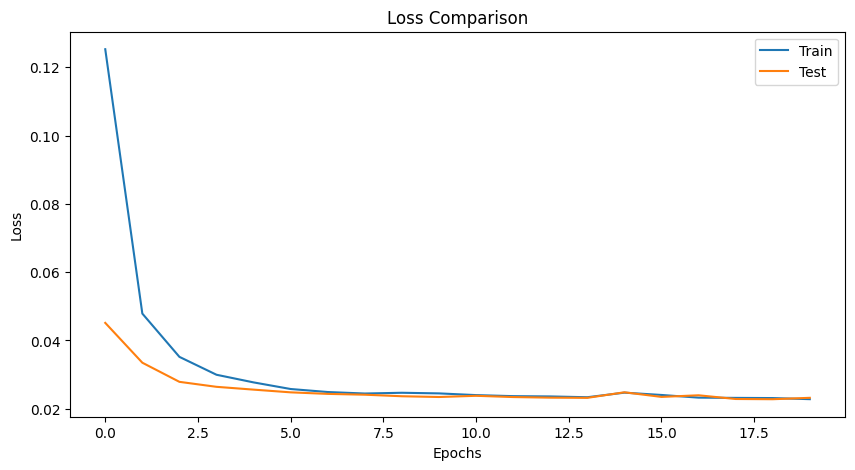

In [26]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(opt["epochs"]), loss_list_train, label="Train")
plt.plot(np.arange(opt["epochs"]), loss_list_test, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend(loc="best")
plt.show()

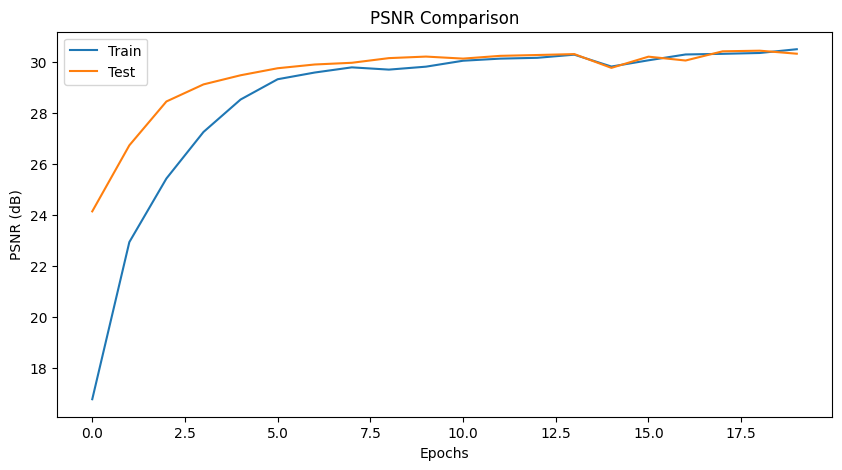

In [27]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(opt["epochs"]), psnr_list_train, label="Train")
plt.plot(np.arange(opt["epochs"]), psnr_list_test, label="Test")
plt.xlabel("Epochs")
plt.ylabel("PSNR (dB)")
plt.title("PSNR Comparison")
plt.legend(loc="best")
plt.show()

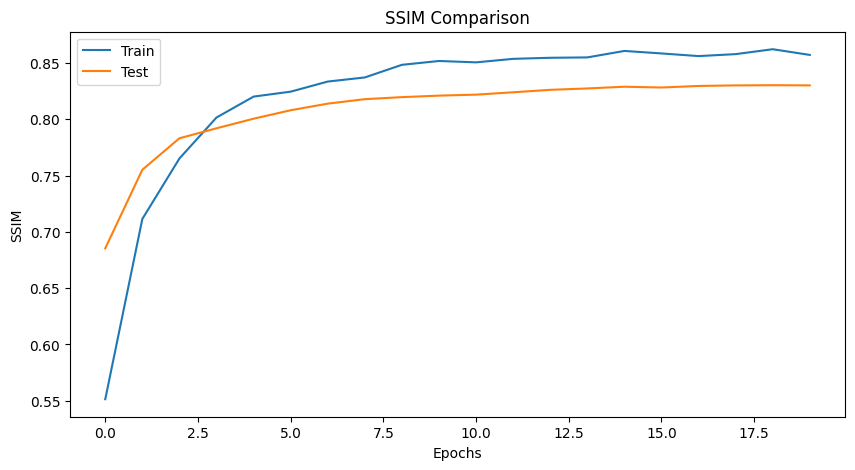

In [28]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(opt["epochs"]), ssim_list_train, label="Train")
plt.plot(np.arange(opt["epochs"]), ssim_list_test, label="Test")
plt.xlabel("Epochs")
plt.ylabel("SSIM")
plt.title("SSIM Comparison")
plt.legend(loc="best")
plt.show()

## 개인 실습

### Autoencoder의 Downsampling과 Upsampling 방식을 바꾸어 가면 그리고 Norm. Layer를 추가하여 모델의 성능을 올려보세요.
*   Downsampling → MaxPooling에서 AvgPooling 또는 Learnable Convolutional Layer로 대체
*   Upsampling → Nearest Neighbor Interpolation에서 Bilinear나 Bicubic으로 대체
    *   mode="bilinear" 또는 mode="bicubic"
*   Normalization → InstanceNorm2d 또는 GroupNorm을 사용
*   Sigma → 25로 변경
*   Crop Size → 256로 변경





In [32]:
class Autoencoder2(nn.Module) :
  def __init__(self, in_channels, hid_channels) :
    super().__init__()

    self.encoder_block_0 = nn.Sequential(
            nn.Conv2d(in_channels, hid_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(hid_channels),
            nn.ReLU(True)
        )
    self.encoder_block_1 = nn.Sequential(
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(hid_channels, hid_channels*2, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(hid_channels*2),
            nn.ReLU(True)
        )
    self.encoder_block_2 = nn.Sequential(
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(hid_channels*2, hid_channels*4, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(hid_channels*4),
            nn.ReLU(True)
        )
    self.encoder_block_3 = nn.Sequential(
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(hid_channels*4, hid_channels*4, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(hid_channels*4),
            nn.ReLU(True)
        )

    self.decoder_block_0 = nn.Sequential(
            nn.Conv2d(hid_channels*4, hid_channels*4, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(hid_channels*4),
            nn.ReLU(True)
        )
    self.decoder_block_1 = nn.Sequential(
            nn.Conv2d(hid_channels*4, hid_channels*2, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(hid_channels*2),
            nn.ReLU(True)
        )
    self.decoder_block_2 = nn.Sequential(
            nn.Conv2d(hid_channels*2, hid_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(hid_channels),
            nn.ReLU(True)
        )
    self.decoder_block_3 = nn.Conv2d(hid_channels, in_channels, kernel_size=3, stride=1, padding=1)
  def forward(self, x) :
    e_0 = self.encoder_block_0(x)
    e_1 = self.encoder_block_1(e_0)
    e_2 = self.encoder_block_2(e_1)
    e_3 = self.encoder_block_3(e_2)

    d_0 = self.decoder_block_0(F.interpolate(e_3, size=e_2.shape[2:], mode="bilinear")) + e_2
    d_1 = self.decoder_block_1(F.interpolate(d_0, size=e_1.shape[2:], mode="bilinear")) + e_1
    d_2 = self.decoder_block_2(F.interpolate(d_1, size=e_0.shape[2:], mode="bilinear")) + e_0
    d_3 = self.decoder_block_3(d_2)

    return d_3

In [33]:
opt = {"seed":42, "in_channels":3, "hid_channels":64, "crop_size":256, "sigma":25, "lr":1e-3, "batch_size":32, "epochs":20, "cuda":torch.cuda.is_available()}